# Cyclic Learning Rate and Snapshot Ensembles

Model ensembles can achieve lower generalization errors than single models but are challenging to develop with deep learning neural networks, given the computational cost of training every model. An alternative is to train multiple model snapshots during a single training run and combine their predictions to make an ensemble prediction. A limitation of this approach is that the saved models will be similar, resulting in similar predictions and predictions errors and not offering many benefits from combining their predictions.

Effective ensembles require a diverse set of skillful ensemble members that have different distributions of prediction errors. One approach to promoting a diversity of models saved during a single training run is to use an aggressive learning rate schedule that forces large changes in the model weights and, in turn, the nature of the model saved at each snapshot. In this tutorial, you will discover how to develop snapshot ensembles of models saved using an aggressive learning rate schedule over a single training run. After completing this tutorial, you will know:

* Snapshot ensembles combine the predictions from multiple models saved during a single training run.
* Diversity in model snapshots can be achieved by aggressively cycling the learning rate used during a single training run.
* How to save model snapshots during a single run and load snapshot models to make ensemble predictions.

## Snapshot Ensembles

A problem with ensemble learning with deep learning methods is the large computational cost of training multiple models. This is because of the use of very deep models and large datasets, which can result in model training times extending to days, weeks, or even months.

One approach to ensemble learning for deep learning neural networks is to collect multiple models from a single training run. This addresses the computational cost of training multiple deep learning models as models can be selected and saved during training, then used to make an ensemble prediction. A key benefit of ensemble learning is improved performance compared to the predictions from single models. This can be achieved by selecting members with good skills but in different ways, providing a diverse set of predictions to be combined. A limitation of collecting multiple models during a single training run is that the models may be good but too similar.

This can be addressed by changing the learning algorithm for the deep neural network to explore different network weights during a single training run that will result in models with differing performances. One way that this can be achieved is by aggressively changing the learning rate used during training. An approach to systematically and aggressively changing the learning rate during training to result in very different network weights is referred to as Stochastic Gradient Descent with Warm Restarts or SGDR for short, described by Ilya Loshchilov and Frank Hutter in their 2017 paper *SGDR: Stochastic Gradient Descent with Warm Restarts*.

Their approach involves systematically changing the learning rate over training epochs, called cosine annealing. This approach requires the specification of two hyperparameters: the initial learning rate and the total number of training epochs. The cosine annealing method has the effect of starting with a large learning rate that is relatively rapidly decreased to a minimum value before being dramatically increased again. The model weights are subjected to the dramatic changes during training, having the effect of using good weights as the starting point for the subsequent learning rate cycle but allowing the learning algorithm to converge to a different solution.

The resetting of the learning rate acts as a simulated restart of the learning process, and the re-use of good weights as the starting point of the restart is referred to as a warm restart, in contrast to a cold restart where a new set of small random numbers may be used as a starting point. The good weights at the bottom of each cycle can be saved to file, providing a snapshot of the model. These snapshots can be collected at the end of the run and used in a model averaging ensemble. The saving and use of these models during an aggressive learning rate schedule is referred to as a Snapshot Ensemble and was described by Gao Huang et al. in their 2017 paper titled *Snapshot Ensembles: Train 1, get M for free* and subsequently also used in an updated version of the Loshchilov and Hutter paper.

The ensemble of models is created during training a single model, therefore, the authors claim that the ensemble forecast is provided at no additional cost.

Although a cosine annealing schedule is used for the learning rate, other aggressive learning rate schedules could be used, such as the simpler cyclical learning rate schedule described by Leslie Smith in the 2017 paper titled Cyclical Learning Rates for Training Neural Networks. Now that we are familiar with the snapshot ensemble technique, we can look at how to implement it in Python with Keras.

## Snapshot Ensembles Case Study

In this section, we will demonstrate how to use the snapshot ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the snapshot ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate the snapshot ensemble. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We use this problem with 1,000 examples, with input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same data points.

In [1]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

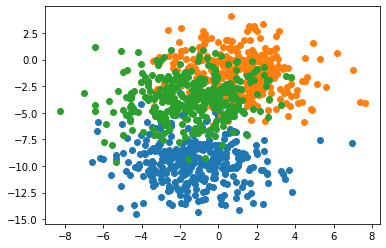

In [2]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance. 

### Multilayer Perceptron Model

Before we define a model, we need to contrive an appropriate problem for a horizontal voting ensemble. In our problem, the training dataset is relatively small. Specifically, there is a 10:1 ratio of examples in the training dataset to the holdout dataset. This mimics a situation where we may have a vast number of unlabeled examples and a small number of labeled examples with which to train a model. We will create 1,100 data points from the blobs problem. The model will be trained on the first 100 points, and the remaining 1,000 will be held back in a test dataset, unavailable to the model.

The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [3]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 25 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and stochastic gradient descent with a small learning rate and momentum.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

The model is fit for 200 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [6]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=1)

Epoch 1/200
4/4 [==============================] - 1s 47ms/step - loss: 1.0706 - accuracy: 0.3657 - val_loss: 0.9721 - val_accuracy: 0.3740
Epoch 2/200
4/4 [==============================] - 0s 16ms/step - loss: 0.9163 - accuracy: 0.4138 - val_loss: 0.9158 - val_accuracy: 0.4850
Epoch 3/200
4/4 [==============================] - 0s 17ms/step - loss: 0.8915 - accuracy: 0.4798 - val_loss: 0.8567 - val_accuracy: 0.5450
Epoch 4/200
4/4 [==============================] - 0s 18ms/step - loss: 0.7999 - accuracy: 0.6520 - val_loss: 0.8133 - val_accuracy: 0.6190
Epoch 5/200
4/4 [==============================] - 0s 15ms/step - loss: 0.7866 - accuracy: 0.6381 - val_loss: 0.7680 - val_accuracy: 0.6660
Epoch 6/200
4/4 [==============================] - 0s 16ms/step - loss: 0.7271 - accuracy: 0.6696 - val_loss: 0.7582 - val_accuracy: 0.6720
Epoch 7/200
4/4 [==============================] - 0s 15ms/step - loss: 0.6504 - accuracy: 0.7359 - val_loss: 0.7354 - val_accuracy: 0.6760
Epoch 8/200
4/4 [===

4/4 [==============================] - 0s 16ms/step - loss: 0.3693 - accuracy: 0.8125 - val_loss: 0.4622 - val_accuracy: 0.7990
Epoch 60/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4093 - accuracy: 0.8176 - val_loss: 0.4511 - val_accuracy: 0.7990
Epoch 61/200
4/4 [==============================] - 0s 19ms/step - loss: 0.3856 - accuracy: 0.8124 - val_loss: 0.4740 - val_accuracy: 0.7820
Epoch 62/200
4/4 [==============================] - 0s 15ms/step - loss: 0.4103 - accuracy: 0.7813 - val_loss: 0.4647 - val_accuracy: 0.7940
Epoch 63/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3817 - accuracy: 0.8094 - val_loss: 0.4533 - val_accuracy: 0.8030
Epoch 64/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3476 - accuracy: 0.8459 - val_loss: 0.4524 - val_accuracy: 0.8090
Epoch 65/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3798 - accuracy: 0.8169 - val_loss: 0.4453 - val_accuracy: 0.8060
Epoch 66/200
4/4 [========

4/4 [==============================] - 0s 16ms/step - loss: 0.3547 - accuracy: 0.8310 - val_loss: 0.5559 - val_accuracy: 0.7680
Epoch 118/200
4/4 [==============================] - 0s 15ms/step - loss: 0.4221 - accuracy: 0.8200 - val_loss: 0.4923 - val_accuracy: 0.7870
Epoch 119/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3721 - accuracy: 0.7981 - val_loss: 0.4558 - val_accuracy: 0.8000
Epoch 120/200
4/4 [==============================] - 0s 16ms/step - loss: 0.3529 - accuracy: 0.8332 - val_loss: 0.4445 - val_accuracy: 0.7970
Epoch 121/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3413 - accuracy: 0.8157 - val_loss: 0.4483 - val_accuracy: 0.8050
Epoch 122/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3465 - accuracy: 0.8219 - val_loss: 0.4417 - val_accuracy: 0.8090
Epoch 123/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3257 - accuracy: 0.8506 - val_loss: 0.4376 - val_accuracy: 0.8200
Epoch 124/200
4/4 [=

Epoch 175/200
4/4 [==============================] - 0s 16ms/step - loss: 0.3795 - accuracy: 0.8065 - val_loss: 0.4790 - val_accuracy: 0.8060
Epoch 176/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4088 - accuracy: 0.7967 - val_loss: 0.4634 - val_accuracy: 0.8070
Epoch 177/200
4/4 [==============================] - 0s 17ms/step - loss: 0.3462 - accuracy: 0.8363 - val_loss: 0.4911 - val_accuracy: 0.7980
Epoch 178/200
4/4 [==============================] - 0s 16ms/step - loss: 0.3388 - accuracy: 0.8270 - val_loss: 0.4595 - val_accuracy: 0.8090
Epoch 179/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3124 - accuracy: 0.8280 - val_loss: 0.4419 - val_accuracy: 0.8100
Epoch 180/200
4/4 [==============================] - 0s 16ms/step - loss: 0.3624 - accuracy: 0.8183 - val_loss: 0.4411 - val_accuracy: 0.8090
Epoch 181/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3250 - accuracy: 0.8360 - val_loss: 0.4497 - val_accuracy: 0.8040
Epoch 

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [7]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.810, Test: 0.828


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

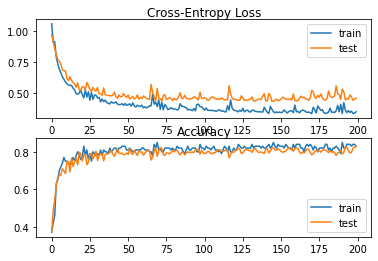

In [8]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [9]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.830, Test: 0.793


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 83% accuracy on the training dataset, which we know is optimistic, and about 79% on the test dataset, which we would expect to be more realistic.

A line plot also shows the learning curves for the model accuracy on the train and test sets over each training epoch. We can see that training accuracy is more optimistic over the whole run, as we noted with the final scores.

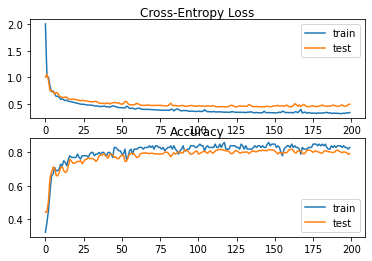

In [10]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

Next, we can look at how to implement an aggressive learning rate schedule.

### Cosine Annealing Learning Rate

### MLP Snapshot Ensemble

## Extensions

Extensions This section lists some ideas for extending the tutorial that you may wish to explore.

* **Vary Cycle Length**. Update the example to use a shorter or longer cycle length and compare results.
* **Vary Maximum Learning Rate**. Update the example to use a larger or smaller maximum learning rate and compare results.
* **Update Learning Rate Per Batch**. Update the example to calculate the learning rate per batch instead of per-epoch.
* **Repeated Evaluation**. Update the example to repeat the evaluation of the model to confirm that the approach indeed leads to improved performance over the final model on the blobs problem.
* **Cyclic Learning Rate**. Update the example to use a cyclic learning rate schedule and compare results.

## Summary

This tutorial taught you to develop snapshot ensembles of models saved using an aggressive learning rate schedule over a single training run. Specifically, you learned:

* Snapshot ensembles combine the predictions from multiple models saved during a single training run.
* Diversity in model snapshots can be achieved by aggressively cycling the learning rate used during a single training run.
* How to save model snapshots during a single run and load snapshot models to make ensemble predictions.